# Import Modules

**General Modules:**
- [Pandas](https://pandas.pydata.org/): Library for Python data analysis
- [NumPy](http://www.numpy.org/): The fundamental package for scientific computing with Python
- [MatplotLib](https://matplotlib.org/): plotting library which produces publication quality figures
- [scikit-learn](https://scikit-learn.org/): Machine Learning in Python

**Chemistry specific:**
- [RDkit](https://www.rdkit.org/): An Open Source library for cheminformatics and machine learning
- [MolVS](https://github.com/mcs07/MolVS): Molecular Validation and Standardization

**Cosmetic**
- [TQDM](https://github.com/tqdm/): For progress bars

In [1]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [68]:
# The averaged random forest model
%reload_ext autoreload
%autoreload 2
from AverageRF import AverageRF
from utils import train_test_split_data

# Functions

In [3]:
def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds, ax=plt):      
    ax.plot(thresholds, precisions[:-1], linestyle="-", color="b", label='Precision')
    ax.plot(thresholds, recalls[:-1], linestyle="-", color="g", label='Recall')
    ax.set_xlabel("Threshold")
    ax.legend(loc='center left')
    ax.set_ylim([0,1])

def plot_precision_recall(precisions, recalls, ax=plt):
    ax.plot(recalls, precisions, linestyle="-")
    ax.plot([0,1], [1,0], 'k--')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.axis([0,1,0,1])

def plot_roc_curve(fpr,tpr,ax=plt):
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot(fpr, tpr, linewidth=1, linestyle="-")
    ax.plot([0,1], [0,1], 'k--')
    ax.axis([0,1,0,1])

def plot_roc_curves(fpr, tpr, aucs, label=None, step=10, ax=plt):
    
    legends = []
   
    fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,5))
    
    fig.suptitle(label)
    
    # Receiver Operating Curves
    ax = axs[0]
    n_models = len(fpr)
    for rate in range(0,n_models,5):
        ax.plot(fpr[rate], tpr[rate], linewidth=1, linestyle="-")
        legends.append(str(rate+1))
    ax.legend(legends)
    ax.plot([0,1], [0,1], 'k--')
    ax.axis([0,1,0,1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #im1 = ax.imshow(n_models, interpolation='nearest', cmap='viridis')
    #fig.colorbar(im1, ax)
    
    # Area under curves
    ax = axs[1]
    y_labels = np.arange(len(prec))*step
    ax.plot(y_labels, aucs, 'bo-')
    ax.set_ylabel('AUC')
    ax.set_xlabel('Inactive size (x n_actives)')

def plot_grid(precisions, recalls, thresh_pr, fpr, tpr, thresh_roc):
    """
    Plots in a grid
    """
    fig, axes = plt.subplots(nrows=2,ncols=2, constrained_layout=True)
    
    # 1. Precision and Recal x Thresholds
    plot_precision_recall_vs_thresholds(precisions, recalls, thresh_pr, ax=axes[0,0])
    
    # 2. Precision x Recall
    plot_precision_recall(precisions, recalls, ax=axes[0,1])
    
    # 3.Receiver Operating Characteristic (ROC) Curve
    plot_roc_curve(fpr,tpr,label='CGD', ax=axes[1,0])

    plt.show()

In [5]:
def evaluate_model(model, X_test, y_test):
    # Evaluate metrics from test set
    # Gather model predictions for test set
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)

    # Calculate perfomance measures
    # ROC
    fpr, tpr, thr_roc = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test,y_proba)

    # Precision x Recall
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score = model.score(X_test, y_pred)

    # Precision x Recll curves
    precisions, recalls, pr_thr = precision_recall_curve(y_test,y_pred)

    #import matplotlib.pyplot as plt
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,9))
    plot_precision_recall_vs_thresholds(precisions, recalls, pr_thr, ax[0,0])
    plot_precision_recall(precisions,recalls,ax[0,1])
    plot_roc_curve(fpr,tpr,ax[1,0])

    res = ax[1,1]
    res.set_axis_off()
    res.annotate(f"Precision = {precision}",(0.2,0.44), size='large')
    res.annotate(f"Recall    = {recall}",(0.2,0.36), size='large')
    res.annotate(f"F1-score  = {f1}",(0.2,0.28), size='large')
    res.annotate(f"Score     = {score}",(0.2,0.2), size='large')
    res.annotate(f"ROC AUC   = {auc}",(0.2,0.12), size='large')

# Load Data

In [6]:
active = pd.read_pickle("./active.pkl.bz2")
inactive = pd.read_pickle("./inactive.pkl.bz2")
inconclusive = pd.read_pickle("./inconclusive.pkl.bz2")

In [7]:
# Results *should* be:
# active       =  (829, 10)
# inactive     =  (50000, 7)
# Inconclusive =  (1526, 6)

print("active       = ", active.shape)
print("inactive     = ", inactive.shape)
print("Inconclusive = ", inconclusive.shape)

active       =  (829, 10)
inactive     =  (50000, 7)
Inconclusive =  (1526, 6)


In [8]:
# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

In [9]:
# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints','ActiveBit']
data = pd.concat([active.filter(columns,axis=1),inactive],
                 axis=0,join='inner', ignore_index=True)

In [10]:
data.columns

Index(['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints',
       'ActiveBit'],
      dtype='object')

# Testing the Classifier

## Morgan Fingerprints

In [11]:
X = np.array(list(data['Morgan Fingerprints'])).astype(int)
y = data['ActiveBit'].values

In [12]:
X.shape, y.shape

((50829, 2048), (50829,))

### Train & Test

In [13]:
# Split the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split_data(X, y, rate_inactives=10)

X_train:  8207 	y_train:  8207 	( 746 actives and 7461 inactives)
X_test:   912  	y_test:   912  	( 83 actives and 829 inactives)


In [73]:
model_morgan = AverageRF(n_forests=5, model_type='classifier', verbosity=1,
                         n_estimators=250,
                         max_features='sqrt',
                         class_weight='balanced_subsample',
                         n_jobs=4)
print("Model type = ", model_morgan.model_type)

Model type =  classifier


In [74]:
# Train with X_train,t_train
model_morgan.fit(X_train,y_train)

SPLIT: 0 [TRAIN: 6564 ,	TEST: 1643 ] 	Time: 8.733282327651978  seconds.
Confusion Matrix = 
 [[1476   17]
 [  82   68]]
	  Precision =  0.8
	  Recall    =  0.4533333333333333
	  F1-score  =  0.5787234042553192
	  R2-score  =  0.9397443700547778
	  ROC AUC   =  0.9452511721366377 

SPLIT: 1 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 8.80662226676941  seconds.
Confusion Matrix = 
 [[1478   14]
 [  72   77]]
	  Precision =  0.8461538461538461
	  Recall    =  0.5167785234899329
	  F1-score  =  0.6416666666666667
	  R2-score  =  0.947592931139549
	  ROC AUC   =  0.9539850117854508 

SPLIT: 2 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 8.932959079742432  seconds.
Confusion Matrix = 
 [[1470   22]
 [  81   68]]
	  Precision =  0.7555555555555555
	  Recall    =  0.4563758389261745
	  F1-score  =  0.5690376569037656
	  R2-score  =  0.9372333942717855
	  ROC AUC   =  0.9542189214963024 

SPLIT: 3 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 9.685747146606445  seconds.
Confusion Matrix = 
 [[1477   15]
 [  91   58]]
	  Pre

In [76]:
morgan_model_stats = pd.DataFrame(model_morgan.stats)

In [78]:
morgan_model_stats.describe()

,Training Times,Precision Scores,Recall Scores,F1 Scores,Predictions R2 Scores,ROC AUC
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,9.166893,0.797942,0.461136,0.583552,0.940417,0.949179
std,0.474549,0.032237,0.047893,0.044247,0.004745,0.008100
min,8.733282,0.755556,0.389262,0.522523,0.935405,0.936707
25%,8.806622,0.793478,0.453333,0.569038,0.937233,0.945251
50%,8.932959,0.794521,0.456376,0.578723,0.939744,0.953985
75%,9.675853,0.800000,0.489933,0.605809,0.942108,0.954219
max,9.685747,0.846154,0.516779,0.641667,0.947593,0.955735


In [64]:
import pickle
with open('morgan_cls.pkl','wb') as handle:
    pickle.dump(model_morgan,handle)

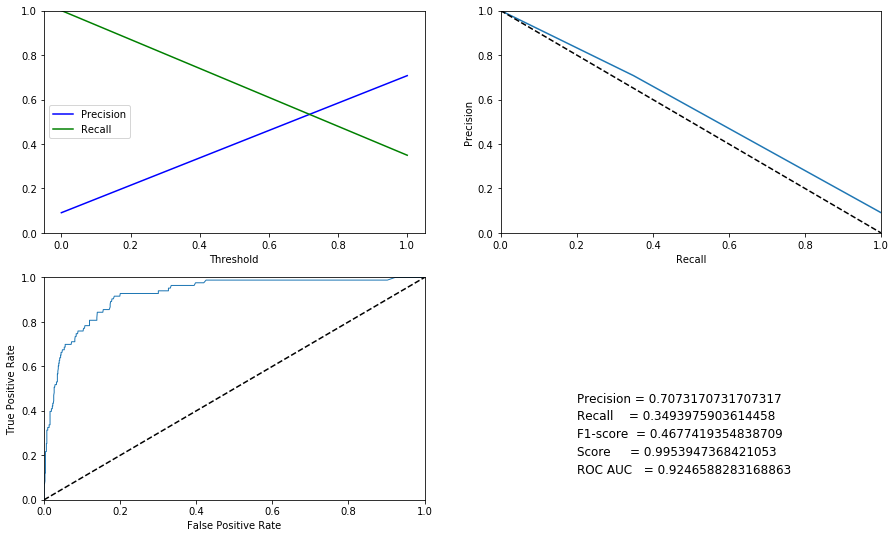

In [79]:
evaluate_model(model_morgan,X_test,y_test)

## RDKit Fingerprints

In [60]:
X = np.array(list(data['RDKit Fingerprints'])).astype(int)
y = data['ActiveBit'].values

X.shape, y.shape

((50829, 2048), (50829,))

### Train & Test

In [61]:
# Split the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split_data(X, y, rate_inactives=10)

X_train:  8207 	y_train:  8207 	( 746 actives and 7461 inactives)
X_test:   912  	y_test:   912  	( 83 actives and 829 inactives)


In [62]:
model_rdkit = AverageRandomForestClassifier(n_forests=5, 
                                            n_estimators=250,
                                            max_features=None,
                                            class_weight='balanced_subsample',
                                            verbose=0, n_jobs=4)

In [63]:
# Train with X_train,t_train
model_rdkit.fit(X_train,y_train)

SPLIT: 0 [TRAIN: 6564 ,	TEST: 1643 ] 	Time: 71.0960681438446  seconds.
Confusion Matrix = 
 [[1481   12]
 [  97   53]]
	  Precision =  0.8153846153846154
	  Recall    =  0.35333333333333333
	  F1-score  =  0.49302325581395345
	  Score     =  0.9336579427875837
	  ROC AUC   =  0.9207032819825853 

SPLIT: 1 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 70.87603735923767  seconds.
Confusion Matrix = 
 [[1480   12]
 [  97   52]]
	  Precision =  0.8125
	  Recall    =  0.348993288590604
	  F1-score  =  0.4882629107981221
	  Score     =  0.9335770871419866
	  ROC AUC   =  0.9132442377242385 

SPLIT: 2 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 73.13820123672485  seconds.
Confusion Matrix = 
 [[1481   11]
 [  90   59]]
	  Precision =  0.8428571428571429
	  Recall    =  0.3959731543624161
	  F1-score  =  0.5388127853881278
	  Score     =  0.9384521633150518
	  ROC AUC   =  0.9276949097648307 

SPLIT: 3 [TRAIN: 6566 ,	TEST: 1641 ] 	Time: 71.5938868522644  seconds.
Confusion Matrix = 
 [[1476   16]
 [  93   56]]
	 

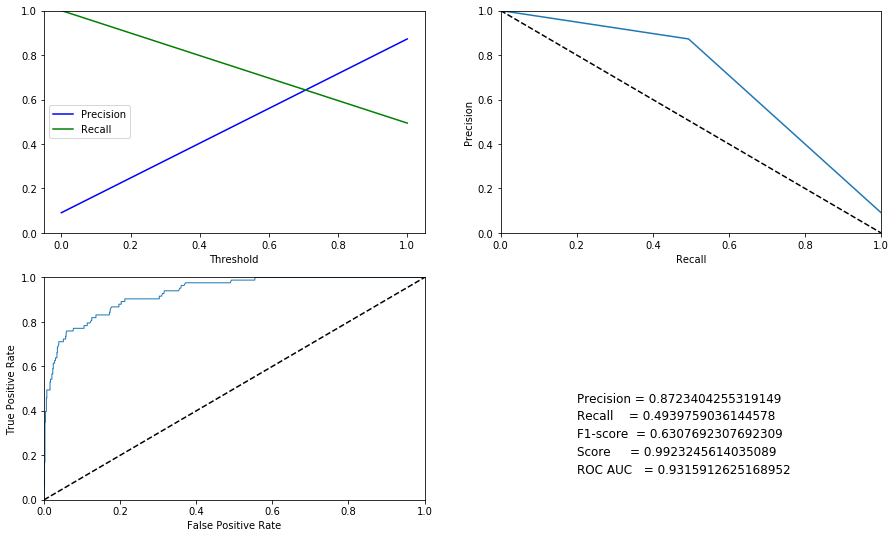

In [64]:
evaluate_model(model_rdkit,X_test,y_test)

# Conclusion

RDKit fingerprints have similar AUC, but less recall and precision. As both recall and precision fall together, the F1-score is basically the same as for Morgan fingerprints.

However, the F1, recall and precision using Morgan fingerprints is slightly better, so **we should use Morgan fingerprints** from now on.

In [66]:
import pickle
with open('train_test_RDKit.pkl','wb') as handle:
    pickle.dump(model_rdkit,handle)

PicklingError: Can't pickle <class 'AverageRandomForests.AverageRandomForestClassifier'>: it's not the same object as AverageRandomForests.AverageRandomForestClassifier